In [1]:
## Libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


## Plot settings
plt.rc('xtick', direction='in', labelsize=14)
plt.rc('ytick', direction='in', labelsize=14)
plt.rc('axes', labelsize=20, titlesize=22)
plt.rc('legend', fontsize=14)
plt.rc('animation', html='jshtml')
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Computer Modern Roman']
plt.rcParams['mathtext.fontset'] = 'cm'

In [2]:
# Load all eigenvalues
pure_evals = np.loadtxt("Eigenvalues/pure.txt")
un_mixed_evals = np.loadtxt("Eigenvalues/unpure_mixed.txt")
un_positive_evals = np.loadtxt("Eigenvalues/unpure_positive.txt")

# Select and order those needed for some index already chosen en analysis script
blt_group = 542, 544, 545, 546, 547
ens = [[x[i] for i in blt_group] for x in [pure_evals, un_mixed_evals, un_positive_evals]]

# Do the same but with phases
# Read the phases in
evec_phases = []
with open('../../../../Separate_files/AB_args.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        ele = line.strip('\n')
        val = float(ele)
        evec_phases.append(val)
        line = reader.readline()
phases = [evec_phases[i] for i in blt_group]

In [3]:
# Define neccessary scalars
N = 8
ks = np.arange(1,9)
ns = np.arange(0,8)

# Define all sites vectors:
site_vecs = []
for i in ns:
    empty_vector = np.zeros(8, dtype= np.complex128)
    empty_vector[i] = 1
    site_vecs.append(empty_vector)

# Calculate ps
ps = [(2*np.pi)/(N)*k for k in ks]

# Calculate eigenvectors
p_vecs = [sum([np.exp(1j*p*n)*n_site for n, n_site in zip(ns, site_vecs)]) for p in ps]

In [4]:
# Construct the chain
# First needed functions
def rotation(phi):
    operator = np.array([[np.cos(phi), -np.sin(phi)],[np.sin(phi), np.cos(phi)]])
    return operator

def jump_finder(input_list, ref_dist):
    # Define empty possible jumps
    total_jumps = []
    jump_indices = []
    for i in input_list:
        # Calculate every jump for every point
        jumps = [x for x in input_list if  ref_dist - 1*10**(-6) < np.linalg.norm( np.array(i) - np.array(x) ) < ref_dist + 1*10**(-6)]
        # Find index of site to which we may jump
        indices = [j for j in range(len(input_list)) for y in jumps if input_list[j][0] == y[0] and input_list[j][1] == y[1]]
        # Append to main lists
        total_jumps.append(jumps)
        jump_indices.append(indices)
    return total_jumps, jump_indices


ref_point = np.array([1,0])
ks = np.arange(0,8)
points = [np.matmul(rotation((np.pi/180)*45*k), ref_point) for k in ks]

# Create jump coordinates by referencing a length
reference_dist = np.linalg.norm(points[0] - points[1])
jump_coors, jump_indices = jump_finder(points, reference_dist)


In [5]:
# Find indices of p_vector by comparing phases with ps
group_temp = [[ps.index(x) for x in ps if abs(x-y) <= 10**(-6)] for y in phases]
group = [item for sublist in group_temp for item in sublist]

# We start out by assuming cp = 1 for all p and thus equally parts of linear combination
# Now define the time evolution function
def time_evolve_evec(group_of_states, time, vec, eval):

    hbar = 1
    t = time

    # Make the group of states in to vectors and multiply with time op
    phis = [np.exp(-1j*(En/hbar)*t)*vec[i] for i, En in zip(group_of_states, eval)]

    # Make a linear combination equally divided
    a = len(phis)
    psi = sum([(1/a)*x for x in phis])

    phi_norm = psi / (np.sqrt(np.vdot(psi,psi)))

    density_of_states = [(x.conj() * x).real for x in phi_norm]
    
    return phi_norm, density_of_states

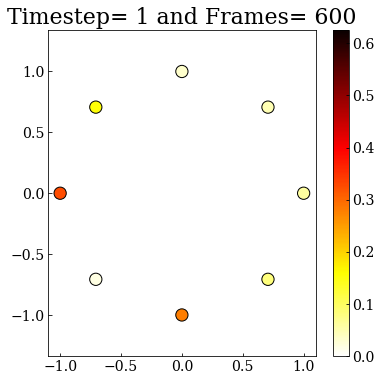

In [6]:
## Magic line for animation
%matplotlib inline
# Attempt at animating time evolution

# Set figure up first
fig, ax = plt.subplots(figsize=(6,6))
# Set bascis
sites = ax.scatter(x=[], y=[], c=[])

xs = [w[0] for w in points]
ys = [w[1] for w in points]


# Set timesteps, state of choice for animation, and number of frames
timestep = 1
# timestep = 1
n_frames = 600

group_of_choice =  group

type = ['pure', 'mixed', 'positive']

for a, b in zip(ens, type):
    psi_0, dos_0 = time_evolve_evec(group_of_choice, 0, p_vecs, a)

    dos_max = max(dos_0)

    #dos_max = 1

    #plt.set_cmap('binary')
    plt.set_cmap('hot_r')
    #cax = ax.scatter(x= xs, y= ys, s= marker_size, c= dos_max, zorder= 2)
    marker_size = 150

    # This function will do the animating
    def update(i):
        plt.clf()
        # t is the steps we progress, timestep sets the steplength
        t = i * timestep

        # Using the time evolution to find density of states for each increment
        psi, dos = time_evolve_evec(group_of_choice, t, p_vecs, a)
        cf = plt.scatter(x= xs, y= ys, c= dos, edgecolors= 'k', s= marker_size, vmin=0, vmax= dos_max)
        plt.colorbar(cf)
        plt.title(f'Timestep= {timestep} and Frames= {n_frames}')
        #plt.legend(loc= 3)
        plt.axis('equal')


    anim = FuncAnimation(fig, update, frames= n_frames, interval=250)

    anim.save(f'Toy_models/' + b + '.gif', writer='imagemagick', fps=30)

    #anim